In [1]:
%load_ext memory_profiler
import numpy as np
import os
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import h5py
import tables
import pandas as pd
import random
from scipy import integrate
from scipy.signal import find_peaks


In [2]:
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=16)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=16)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=16)    # legend fontsize
matplotlib.rc('figure', titlesize=16)  # fontsize of the figure title
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rc('figure.subplot', hspace=  0.4)
fs = 1/2e-9
def process_data(trace, recordlength):
    try:
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    except ValueError:
        trace = trace[:int(np.floor(len(trace)/recordlength))*recordlength,]
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    data= traceR-np.expand_dims(traceR[:,100:2000].mean(axis=1), axis=1)
#     print ('input trace length',trace.shape, 'processed trace shape',  data.shape)
    return data
def create_template(traces):
    template = np.mean(traces, axis = 0)
    template_norm= -template/min(template)
    return template,template_norm

In [3]:
templateEM_Tl,  TemplateEM_Tl = create_template(np.load('templates/Tl_template_pulses.npy'))
templateHAD_Tl,  TemplateHAD_Tl = create_template(np.load('templates/Tl_template_pulses_neutron.npy'))

templateEM_p,  TemplateEM_p = create_template(np.load('templates/pure_template_pulses.npy'))
templateHAD_p,  TemplateHAD_p = create_template(np.load('templates/pure_template_pulses_neutron.npy'))


In [124]:


def clippedwaveformsindex(data, clippingstart = -15100):
    clippedIdx = []
    data_max_idx = np.argmin(data, axis=1) 
    for i in range(len(data)):
        if data[i][data_max_idx[i]] < clippingstart:
            clippedIdx.append(i)
    return clippedIdx


def glitchesindex(data, threshold = 5):
    glitchesIdx = []
    
    std = ((data[:, 100:1000].std(axis=1)).reshape(len(data),1))
    t0idx = np.argmax(data<-(10*std), axis=1)   
        
    data_max_idx = np.argmin(data, axis=1)
    
    for i in range(len(data)):
        if data_max_idx[i] - t0idx[i] < threshold:
            glitchesIdx.append(i)
    return glitchesIdx


def pileupindex(data, ctype):
    pileupIdx, noisyIdx = [], []

    energy = np.sum(data/np.min(data, axis =1)[:, None], axis =1)
    
    if ctype == 'pure': distancefactor, prominencefactor = 15,  0.085
    else: distancefactor, prominencefactor = 200, 0.4
    if ctype == 'pure': threshold_min, threshold_max = 15,40
    else: threshold_min, threshold_max = 350,900
        
    data_max_idx = np.argmin(data, axis=1)
    data_max = data[np.arange(len(data_max_idx)),data_max_idx]  
    for i in range(0, len(data)):
        peaks, peak_properties = find_peaks(-data[i], prominence =(-data_max[i]*prominencefactor), distance=distancefactor)
        if len(peaks)>1 :
            pileupIdx.append(i)
        if energy[i] > threshold_max or energy[i] < threshold_min:
            noisyIdx.append(i)
    return pileupIdx, noisyIdx


In [98]:
%%time
chunks = pd.read_csv("wavedumpdata/wavedump_pure_run12_21-04-27_23-32-09.txt", skiprows = 15000 , chunksize = 15000*1000,  header = None)
norm_int_p_cosmics = []
for chunk in chunks:
    actual_block_size = int(chunk.shape[0]/15000)
#     print('ac = ', actual_block_size)
    newdata = chunk[:actual_block_size*15000].values.reshape(actual_block_size, 15000)
    data_p= newdata-np.expand_dims(newdata[:,100:1000].mean(axis=1), axis=1)
#     print('pure')
    clip_idx = clippedwaveformsindex(data_p, clippingstart = -15100)
#     print('------ clip', clip_idx)
#     print ('***************************************')


    # clip_idx = getclippedwaveformsindex(data_p_ , clippingstart = -15100)
    # print(clip_idx)


    glitch_idx = glitchesindex(data_p)
#     print('------ glitch', glitch_idx)
#     print ('***************************************')

    # t0_ = findT0(data_p, threshold=10)
    # glitch_idx = getglitchesindex(data_p, t0_,  limit = 5)
    # print(glitch_idx)
    pileup_idx, noisy = pileupindex(data_p, ctype = 'pure')
#     print('------ pileup', pileup_idx , noisy)
#     print( list (set (noisy) - set( pileup_idx + glitch_idx + clip_idx)))
    pp = list(set(pileup_idx+glitch_idx+clip_idx)) 
    data_p = np.delete(data_p, pp, axis =0)
#     for n in  pp: 
# #         plt.figure(dpi=100)
#         plt.figure(figsize=(20, 12))
#         plt.subplot(2,2,1)
#     #     plt.plot(np.arange(15000), data_p[n], label='Signal %s'%n, color='blue', alpha=0.5)
#     #     plt.plot(np.arange(15000), data_p[100], label='Signal 100', color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), -data_p[n]/min(data_p[n]), label='Signal %s'%n, color='blue', alpha=0.5)
# #         plt.plot(np.arange(15000), -data_p[100]/min(data_p[100]), label='Normal EM pulse', color='purple', alpha=0.5)
#     #     plt.vlines(t0_[n], -1, 0, color = 'red')
#     #     plt.vlines(t0[n], -1, 0, color = 'green')
# #         plt.xlim(7.2/2e-3,7.8/2e-3)
#         plt.title('CsI pure')
#         plt.grid(linestyle='dotted')
#         plt.legend()
#         plt.subplot(2,2,2)
#     #     plt.plot(np.arange(15000), data_p[n], label='Signal %s'%n, color='blue', alpha=0.5)
#     #     plt.plot(np.arange(15000), data_p[100], label='Signal 100', color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), -data_p[n]/min(data_p[n]), label='int_energy %s'%np.sum(data_p[n]/np.min(data_p[n])), color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), TemplateEM_p, label='Template pulse for ref', color='purple', alpha=0.5)
#     #     plt.vlines(t0_[n], -1, 0, color = 'red')
#     #     plt.vlines(t0[n], -1, 0, color = 'green')
#         plt.xlim(7.2/2e-3,7.8/2e-3)
#         plt.title('CsI pure Signal # %s'%n)
#         plt.grid(linestyle='dotted')
#         plt.legend()
#         plt.show()
    norm_int_p_cosmics = np.append(norm_int_p_cosmics, np.sum(data_p/np.min(data_p, axis=1)[:,None], axis=1), axis = 0) 

CPU times: user 45.5 s, sys: 9.29 s, total: 54.8 s
Wall time: 56.4 s


In [99]:
%%time
chunks = pd.read_csv("wavedumpdata/XFEL/wavedump_pure_XFELtesting_21-07-09_02-27-57.txt", skiprows = 15000 , chunksize = 15000*1000,  header = None)
norm_intXF_p = []
for chunk in chunks:
    actual_block_size = int(chunk.shape[0]/15000)
#     print('ac = ', actual_block_size)
    newdata = chunk[:actual_block_size*15000].values.reshape(actual_block_size, 15000)
    data_p= newdata-np.expand_dims(newdata[:,100:1000].mean(axis=1), axis=1)
#     print('pure')
    clip_idx = clippedwaveformsindex(data_p, clippingstart = -15100)
#     print('------ clip', clip_idx)
#     print ('***************************************')


    # clip_idx = getclippedwaveformsindex(data_p_ , clippingstart = -15100)
    # print(clip_idx)


    glitch_idx = glitchesindex(data_p)
#     print('------ glitch', glitch_idx)
#     print ('***************************************')

    # t0_ = findT0(data_p, threshold=10)
    # glitch_idx = getglitchesindex(data_p, t0_,  limit = 5)
    # print(glitch_idx)
    pileup_idx, noisy = pileupindex(data_p, ctype = 'pure')
#     print('------ pileup', pileup_idx , noisy)
#     print( list (set (noisy) - set( pileup_idx + glitch_idx + clip_idx)))
    pp = list(set(pileup_idx+glitch_idx+clip_idx)) 
    data_p = np.delete(data_p, pp, axis =0)
#     for n in  pp: 
# #         plt.figure(dpi=100)
#         plt.figure(figsize=(20, 12))
#         plt.subplot(2,2,1)
#     #     plt.plot(np.arange(15000), data_p[n], label='Signal %s'%n, color='blue', alpha=0.5)
#     #     plt.plot(np.arange(15000), data_p[100], label='Signal 100', color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), -data_p[n]/min(data_p[n]), label='Signal %s'%n, color='blue', alpha=0.5)
# #         plt.plot(np.arange(15000), -data_p[100]/min(data_p[100]), label='Normal EM pulse', color='purple', alpha=0.5)
#     #     plt.vlines(t0_[n], -1, 0, color = 'red')
#     #     plt.vlines(t0[n], -1, 0, color = 'green')
# #         plt.xlim(7.2/2e-3,7.8/2e-3)
#         plt.title('CsI pure')
#         plt.grid(linestyle='dotted')
#         plt.legend()
#         plt.subplot(2,2,2)
#     #     plt.plot(np.arange(15000), data_p[n], label='Signal %s'%n, color='blue', alpha=0.5)
#     #     plt.plot(np.arange(15000), data_p[100], label='Signal 100', color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), -data_p[n]/min(data_p[n]), label='int_energy %s'%np.sum(data_p[n]/np.min(data_p[n])), color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), TemplateEM_p, label='Template pulse for ref', color='purple', alpha=0.5)
#     #     plt.vlines(t0_[n], -1, 0, color = 'red')
#     #     plt.vlines(t0[n], -1, 0, color = 'green')
#         plt.xlim(7.2/2e-3,7.8/2e-3)
#         plt.title('CsI pure Signal # %s'%n)
#         plt.grid(linestyle='dotted')
#         plt.legend()
#         plt.show()
    norm_intXF_p = np.append(norm_intXF_p, np.sum(data_p/np.min(data_p, axis=1)[:,None], axis=1), axis = 0) 

CPU times: user 56.9 s, sys: 12.9 s, total: 1min 9s
Wall time: 1min 11s


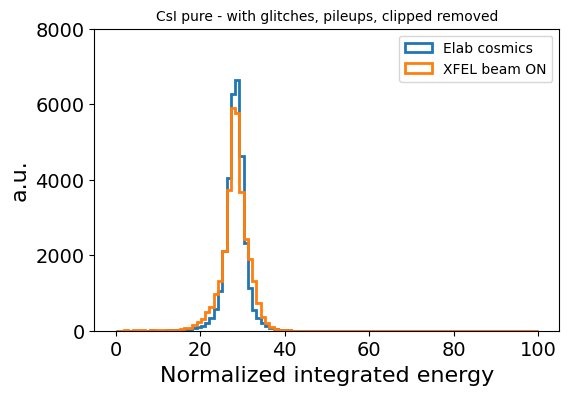

In [103]:
bins = np.linspace (0,100, 100)
plt.hist(norm_int_p_cosmics[:len(norm_intXF)], bins = bins, histtype = 'step', linewidth =2, label = 'Elab cosmics')
plt.hist(norm_intXF_p, bins = bins, histtype = 'step',linewidth =2,  label = 'XFEL beam ON')
# plt.vlines([15,40], 0 , 8000, color = 'red', linestyle = '--', label = 'int_energy cut')
plt.title('CsI pure - with glitches, pileups, clipped removed', fontsize =10 )
plt.ylim(0,8000)
plt.ylabel('a.u.')
plt.xlabel('Normalized integrated energy')
plt.legend(fontsize =10 )
plt.show()

In [78]:
%%time
chunks = pd.read_csv("wavedumpdata/wavedump_Tl_run12_21-04-27_11-48-49.txt", skiprows = 15000 , chunksize = 15000*1000,  header = None)
norm_int_Tl_cosmics_ = []
for chunk in chunks:
    actual_block_size = int(chunk.shape[0]/15000)
#     print('ac = ', actual_block_size)
    newdata = chunk[:actual_block_size*15000].values.reshape(actual_block_size, 15000)
    data_Tl= newdata-np.expand_dims(newdata[:,100:1000].mean(axis=1), axis=1)
#     print('pTl')
    clip_idx = clippedwaveformsindex(data_Tl, clippingstart = -15100)
#     print('------ clip', clip_idx)
#     print ('***************************************')


    # clip_idx = getclippedwaveformsindex(data_Tl_ , clippingstart = -15100)
    # print(clip_idx)


    glitch_idx = glitchesindex(data_Tl)
#     print('------ glitch', glitch_idx)
#     print ('***************************************')

    # t0_ = findT0(data_Tl, threshold=10)
    # glitch_idx = getglitchesindex(data_Tl, t0_,  limit = 5)
    # print(glitch_idx)


    pileup_idx, noisy = pileupindex(data_Tl, ctype = 'Tl')
#     print('------ pileup', pileup_idx, noisy)
#     pp = list(set(pileup_idx+glitch_idx+clip_idx)) 
#     data_Tl = np.delete(data_Tl, pp, axis =0)
#     print(pp)
#     for n in  pp:    
# #         plt.figTl(dpi=100)
#         plt.figure(figsize=(20, 12))
#         plt.subplot(2,2,1)
#     #     plt.plot(np.arange(15000), data_Tl[n], label='Signal %s'%n, color='blue', alpha=0.5)
#     #     plt.plot(np.arange(15000), data_Tl[100], label='Signal 100', color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), -data_Tl[n]/min(data_Tl[n]), label='Signal %s'%n, color='blue', alpha=0.5)
# #         plt.plot(np.arange(15000), -data_Tl[100]/min(data_Tl[100]), label='Normal EM pulse', color='purple', alpha=0.5)
#     #     plt.vlines(t0_[n], -1, 0, color = 'red')
#     #     plt.vlines(t0[n], -1, 0, color = 'green')
# #         plt.xlim(7.2/2e-3,7.8/2e-3)
#         plt.title('CsI Tl')
#         plt.grid(linestyle='dotted')
#         plt.legend()
#         plt.subplot(2,2,2)
#     #     plt.plot(np.arange(15000), data_Tl[n], label='Signal %s'%n, color='blue', alpha=0.5)
#     #     plt.plot(np.arange(15000), data_Tl[100], label='Signal 100', color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), -data_Tl[n]/min(data_Tl[n]), label='int_energy %s'%np.sum(data_Tl[n]/np.min(data_Tl[n])), color='blue', alpha=0.5)
#         plt.plot(np.arange(15000), TemplateEM_Tl, label='Template pulse for ref', color='purple', alpha=0.5)
# #         plt.plot(np.arange(15000), -data_Tl[100]/min(data_Tl[100]), label='Normal EM pulse', color='purple', alpha=0.5)
#     #     plt.vlines(t0_[n], -1, 0, color = 'red')
#     #     plt.vlines(t0[n], -1, 0, color = 'green')
#         plt.xlim(7.2/2e-3,7.8/2e-3)
#         plt.title('CsI Tl Signal # %s'%n)
#         plt.grid(linestyle='dotted')
#         plt.legend()
#         plt.show()
#     print(np.sum(data_Tl/np.min(data_Tl, axis=1)[:,None], axis=1)) 
    norm_int_Tl_cosmics_ = np.append(norm_int_Tl_cosmics_, np.sum(data_Tl/np.min(data_Tl, axis=1)[:,None], axis=1), axis = 0) 

CPU times: user 34 s, sys: 7.65 s, total: 41.7 s
Wall time: 42.4 s


In [72]:
len(norm_intXF)

31129

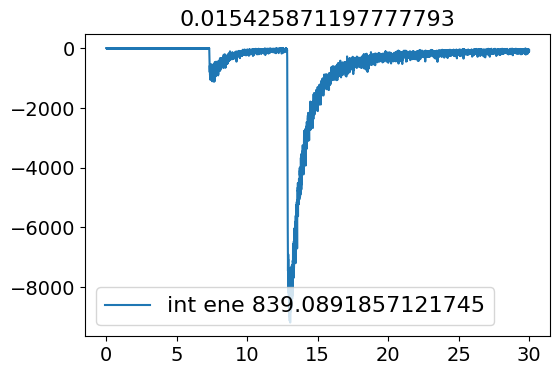

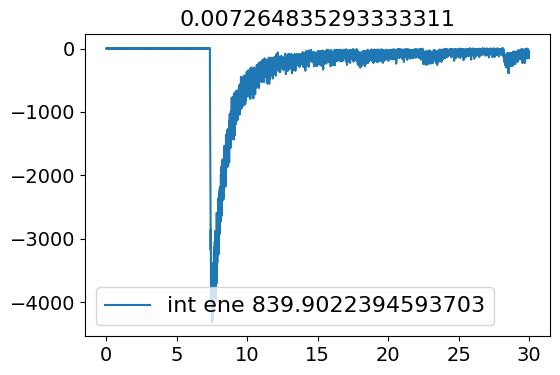

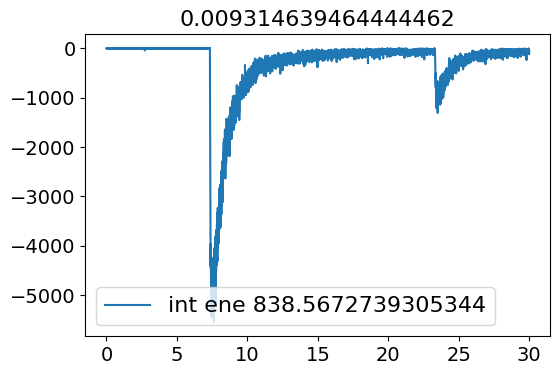

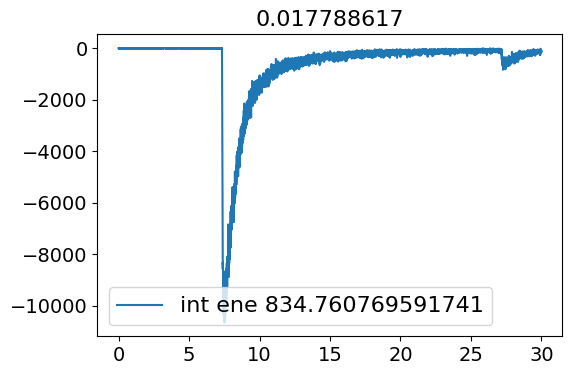

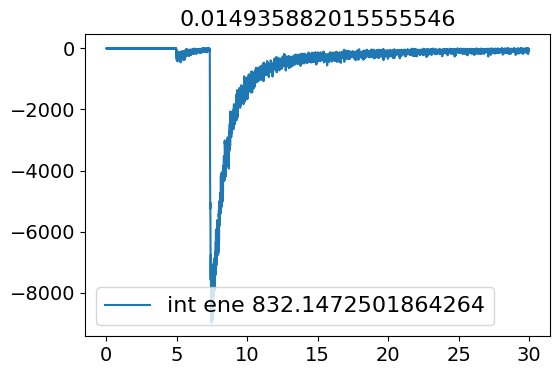

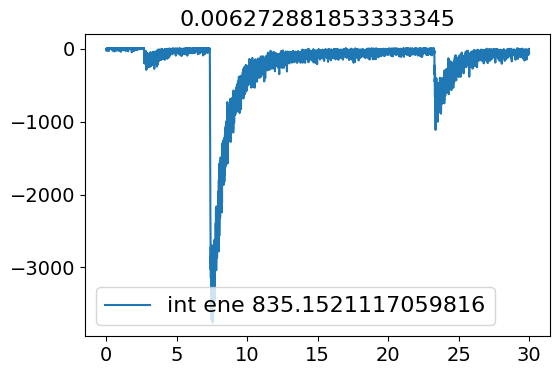

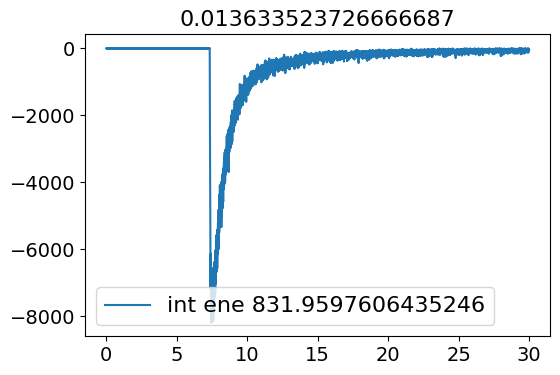

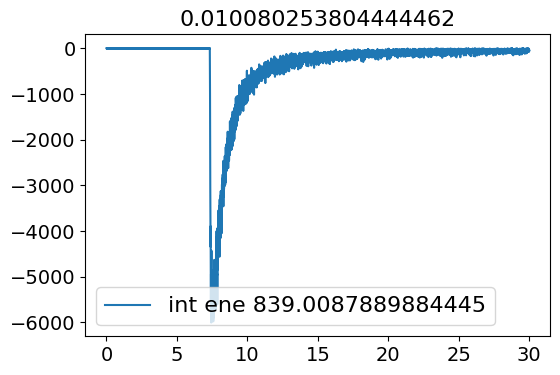

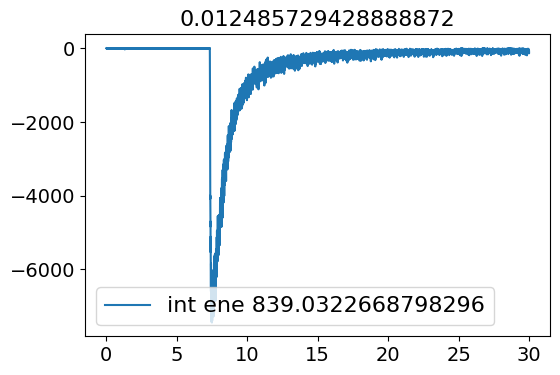

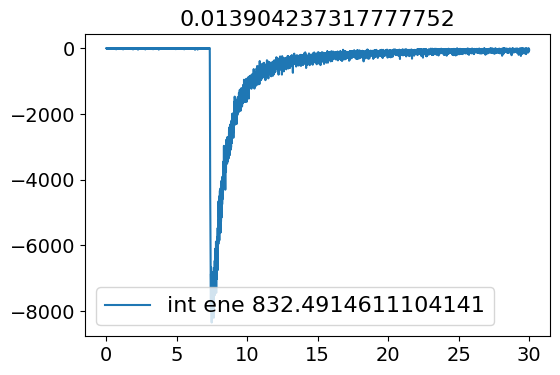

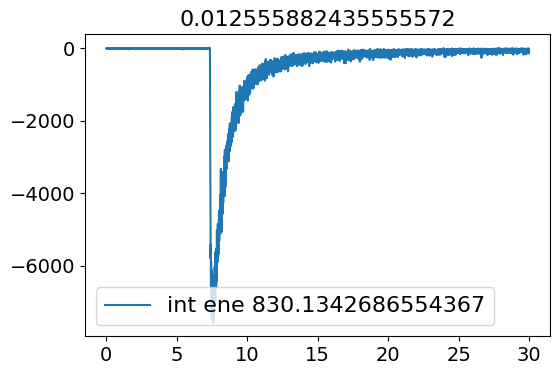

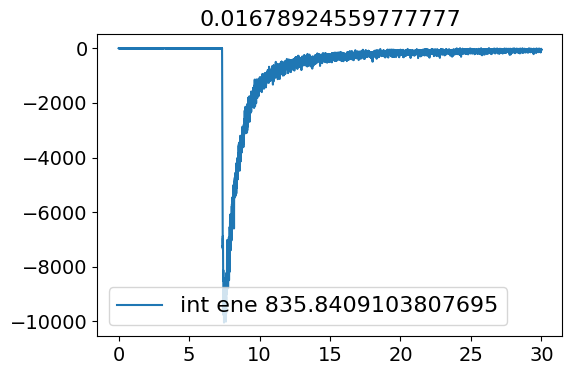

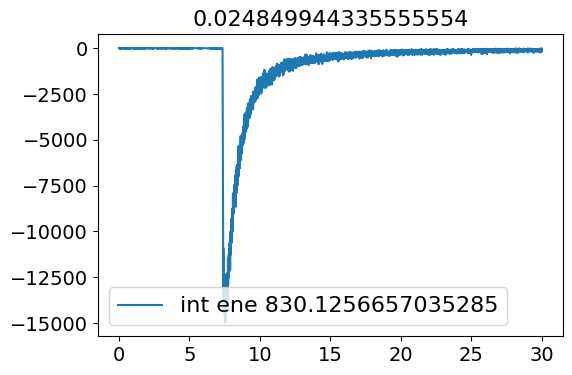

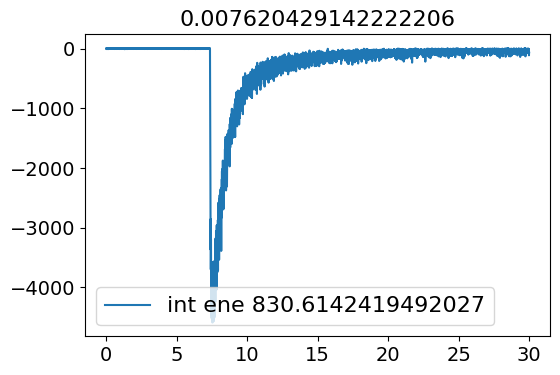

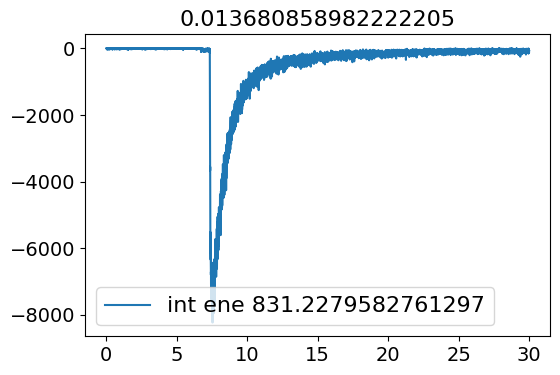

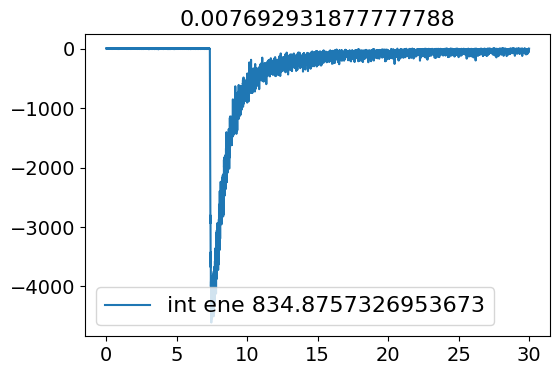

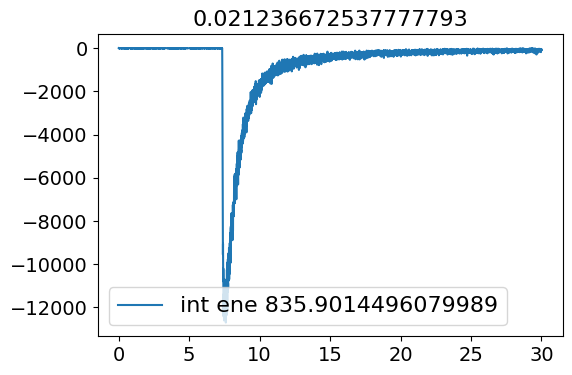

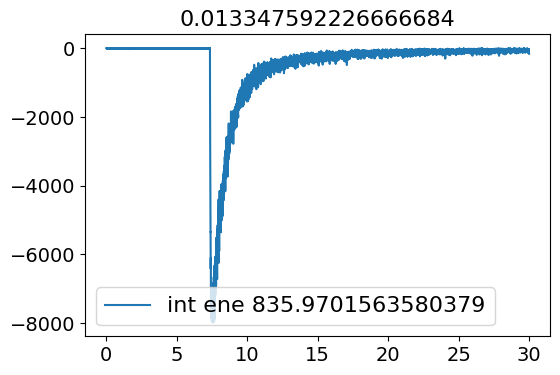

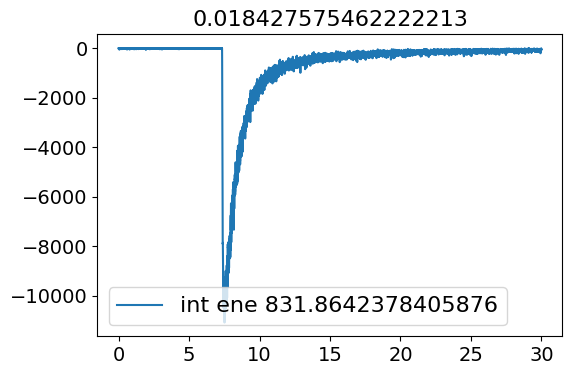

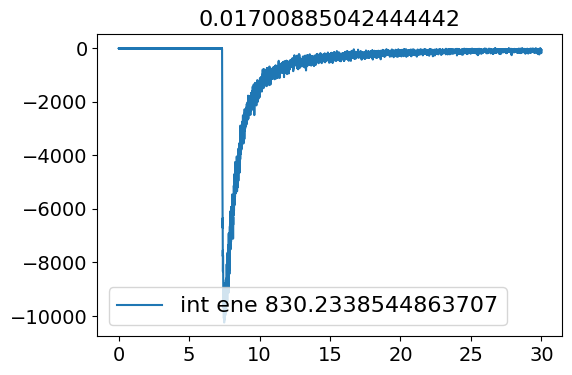

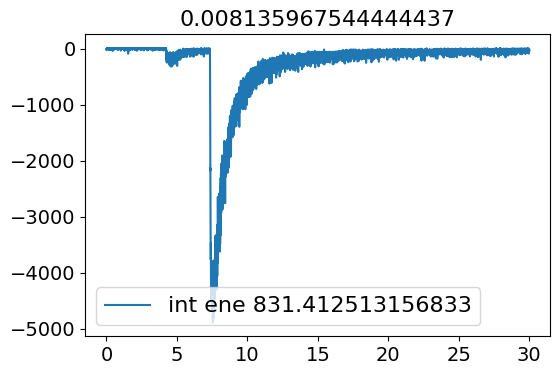

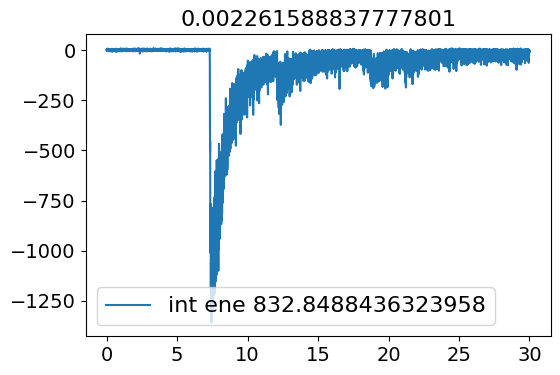

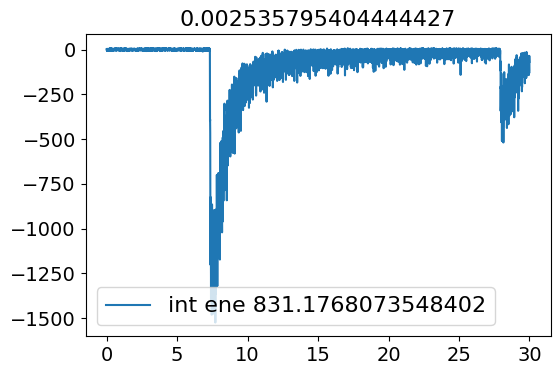

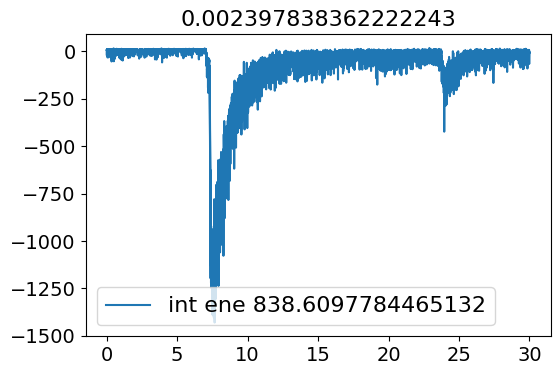

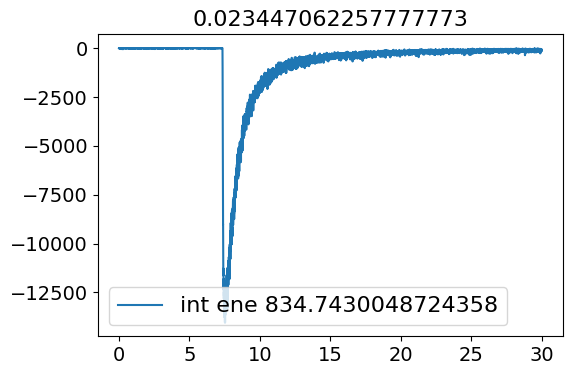

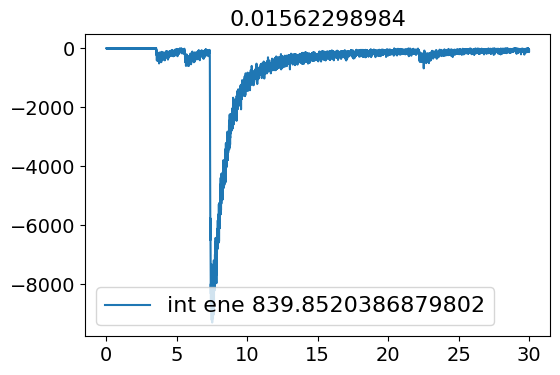

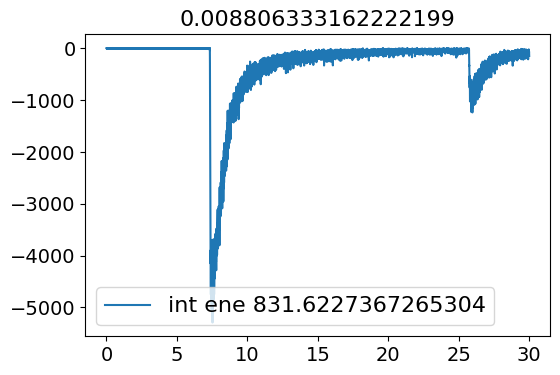

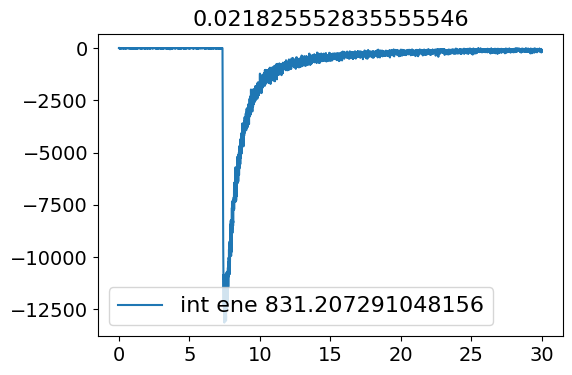

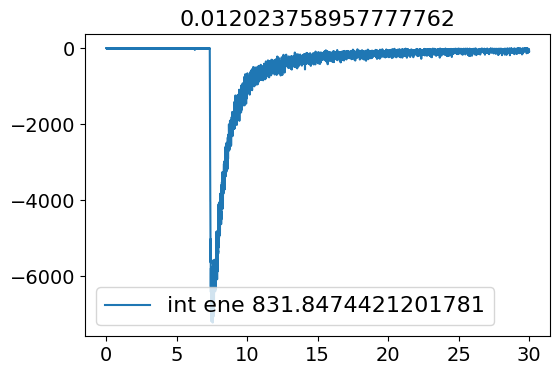

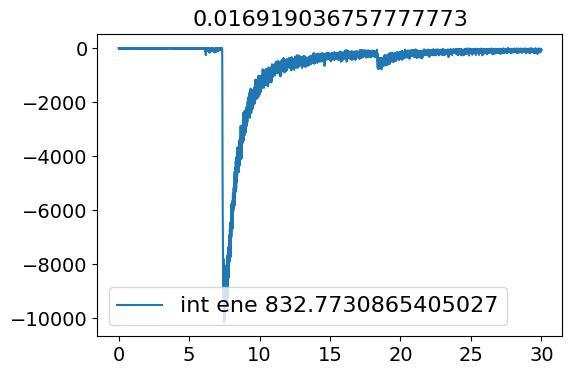

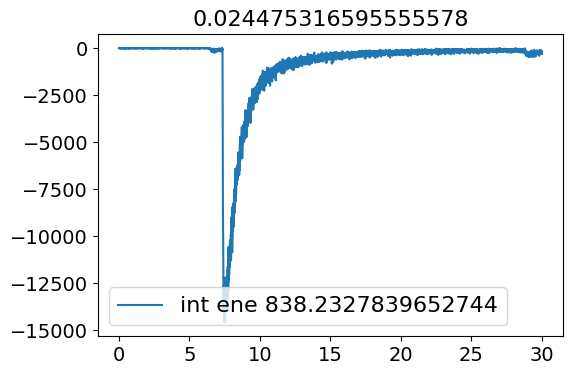

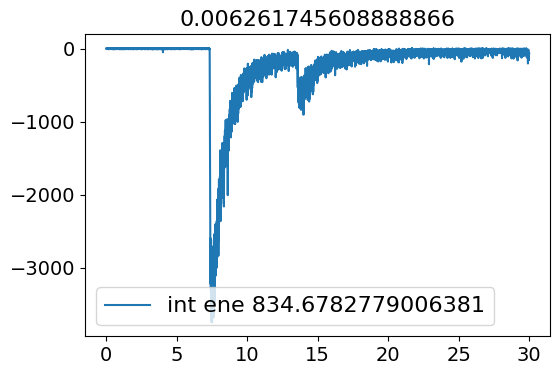

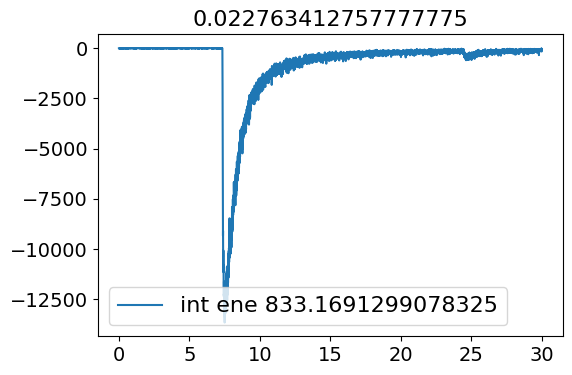

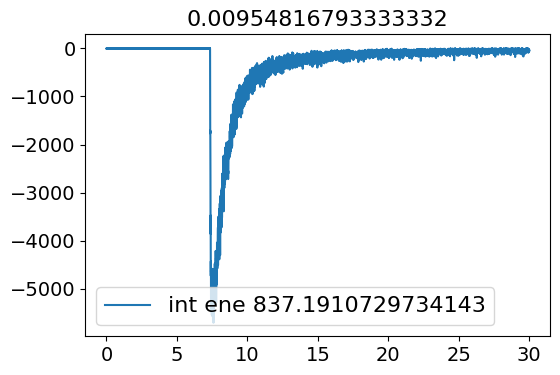

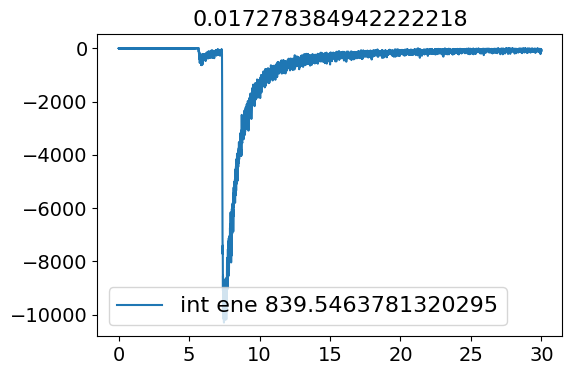

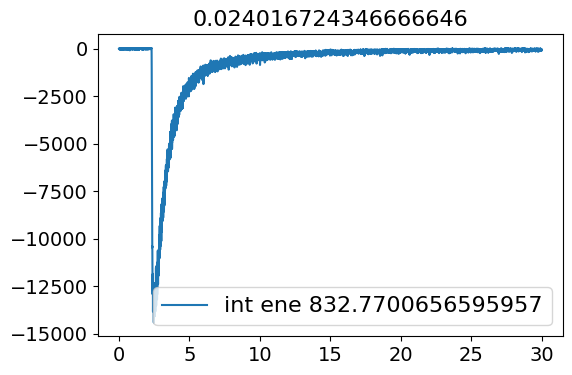

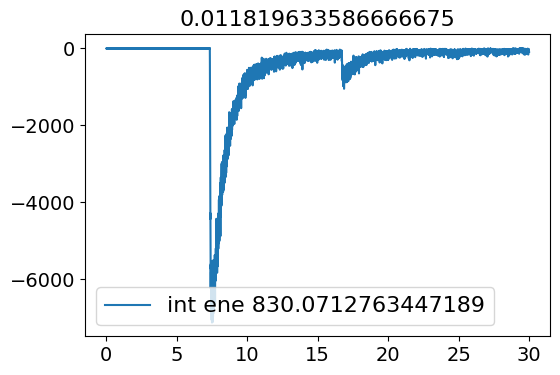

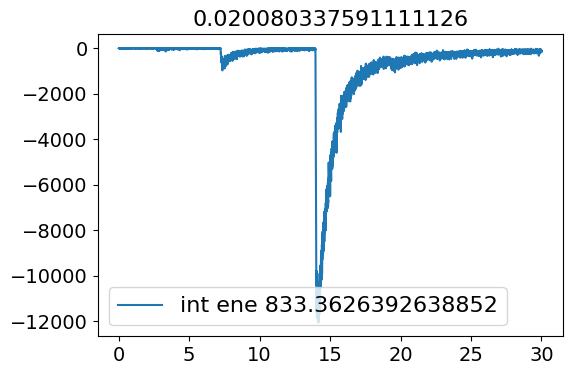

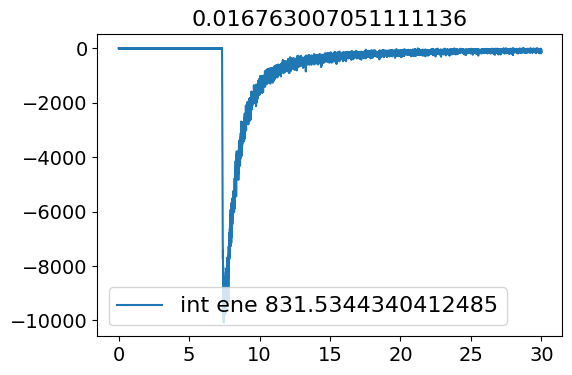

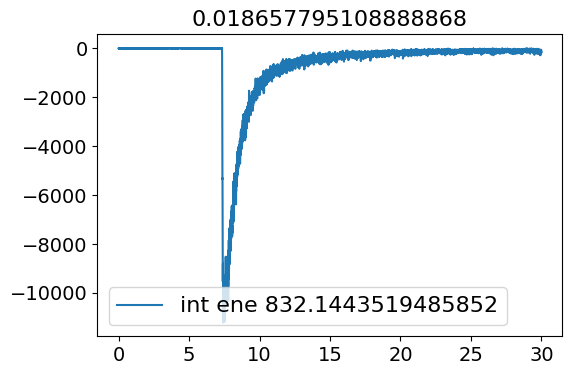

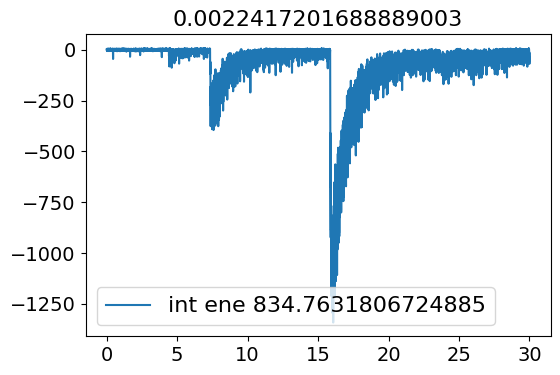

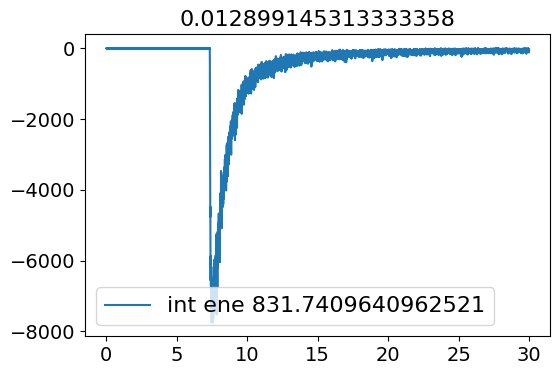

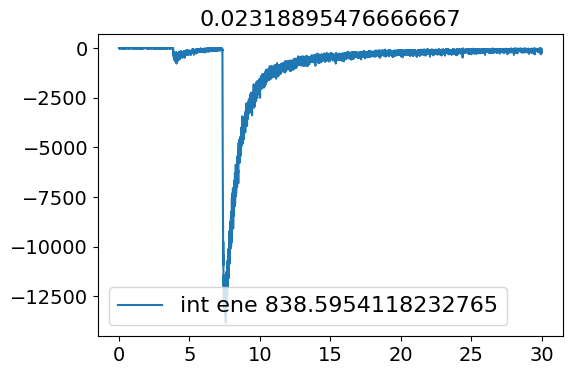

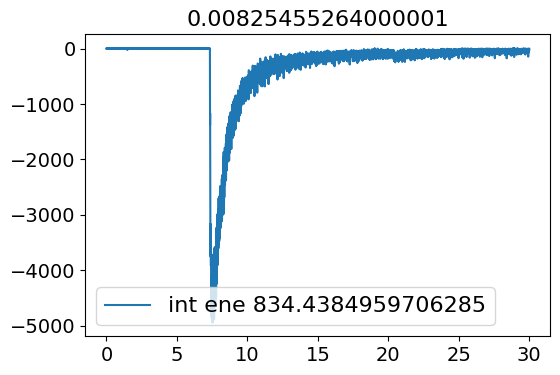

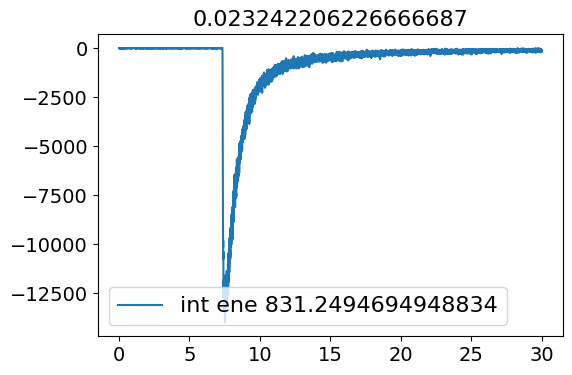

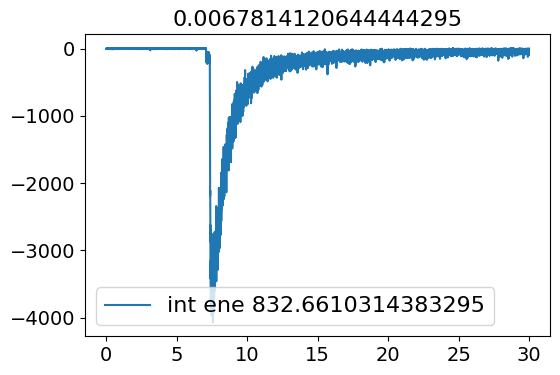

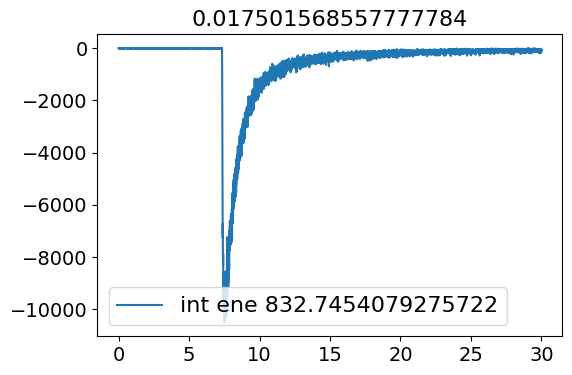

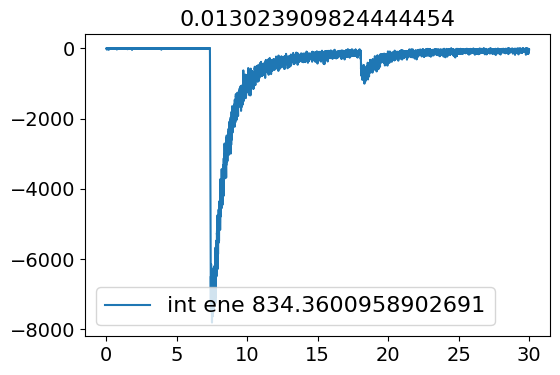

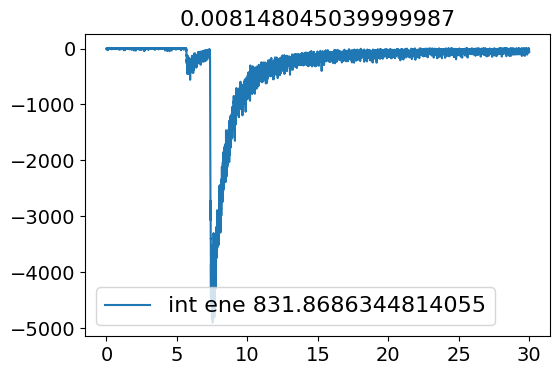

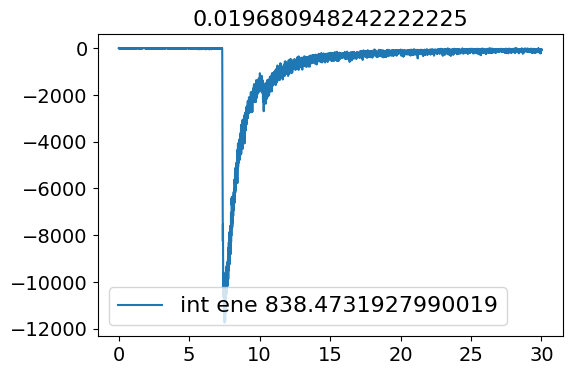

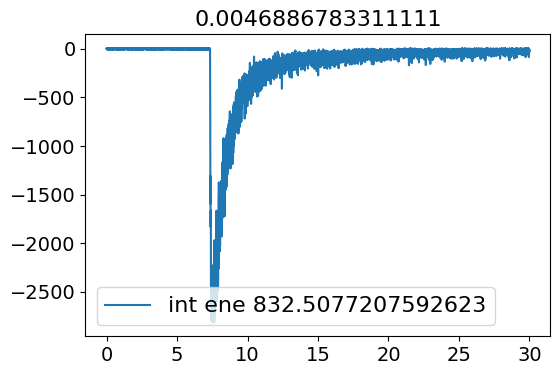

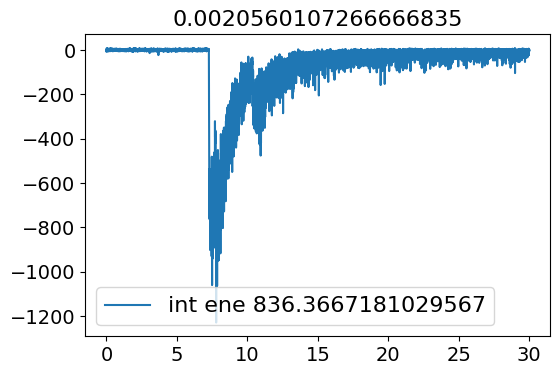

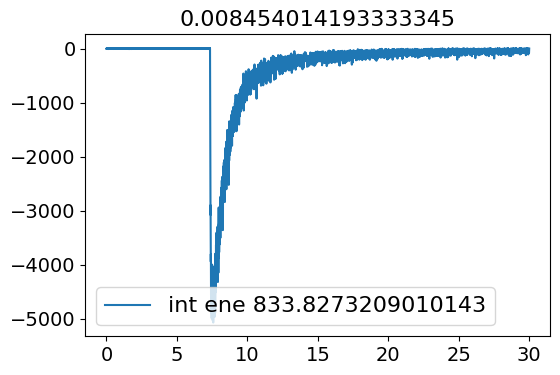

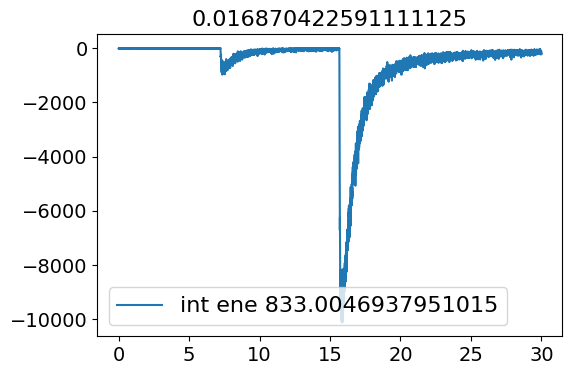

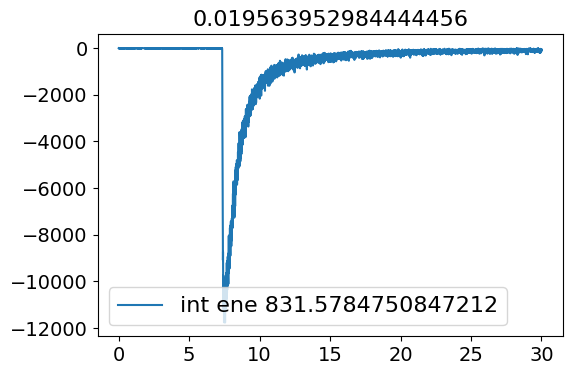

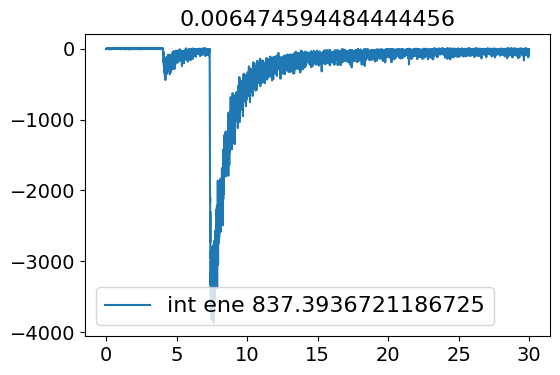

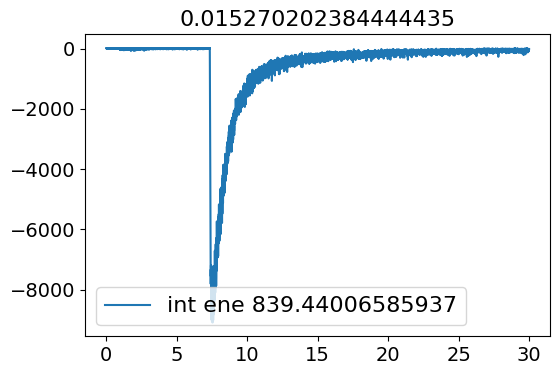

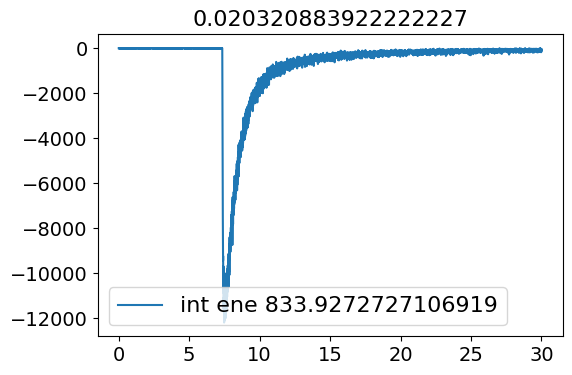

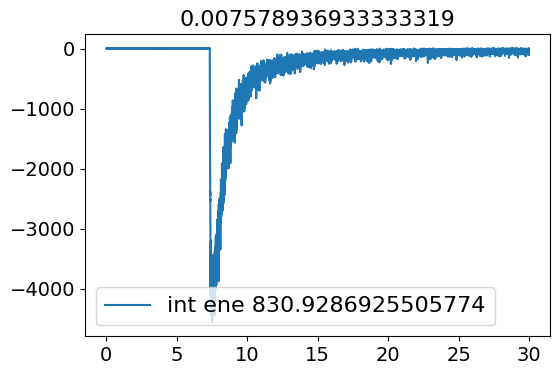

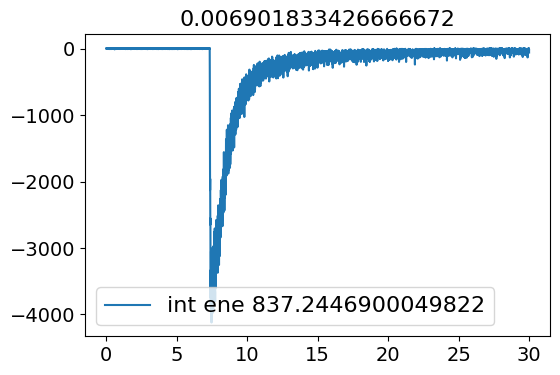

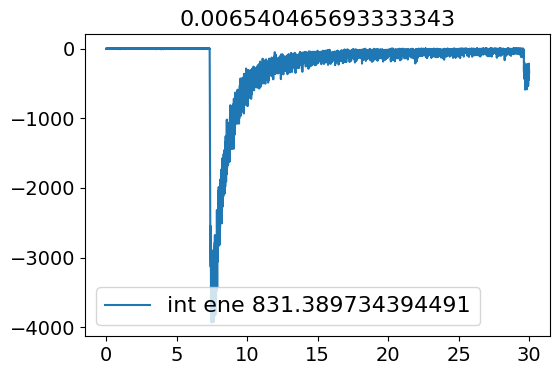

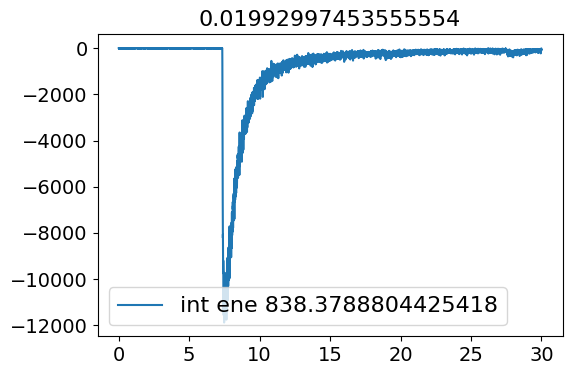

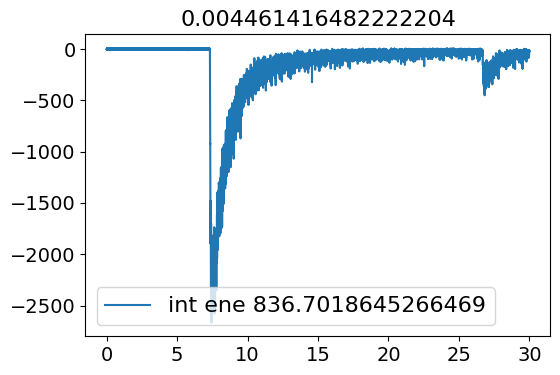

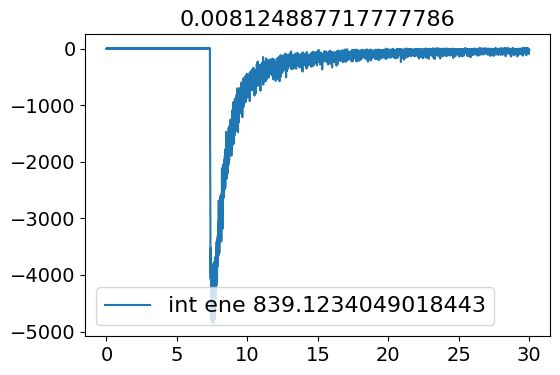

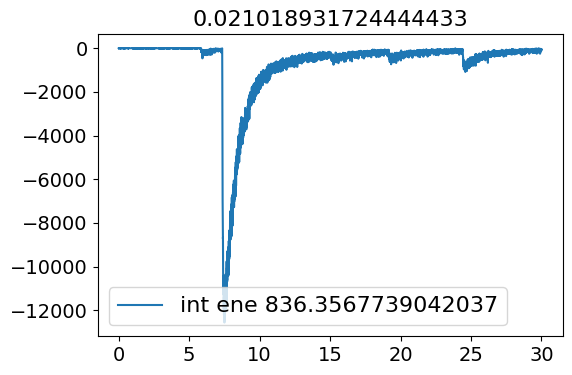

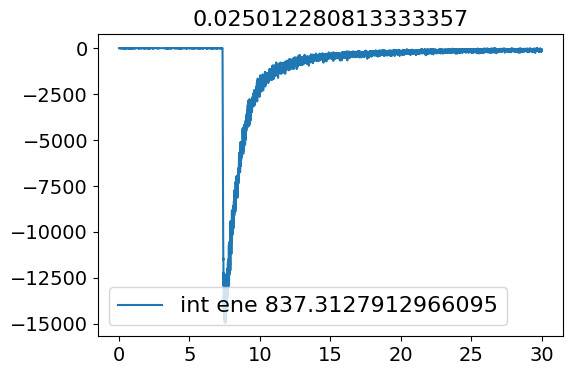

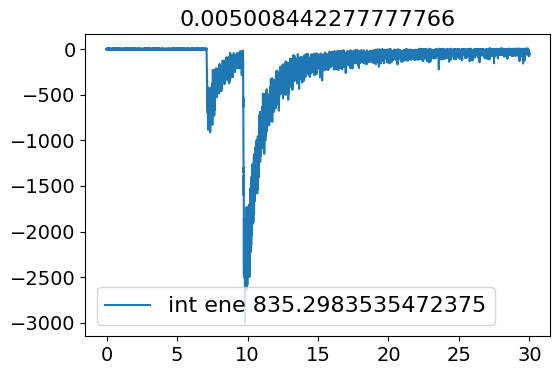

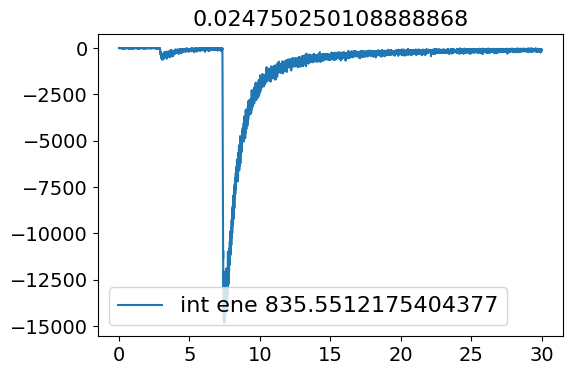

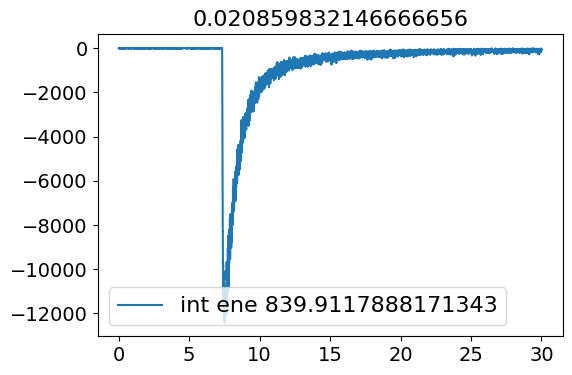

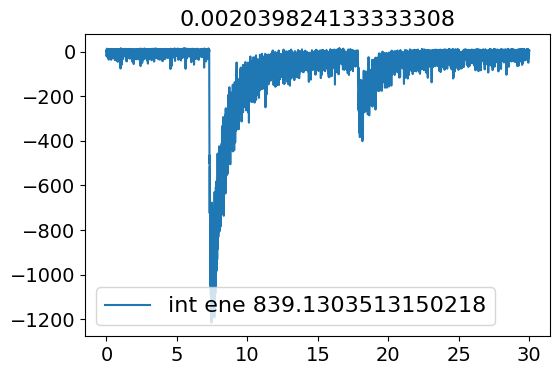

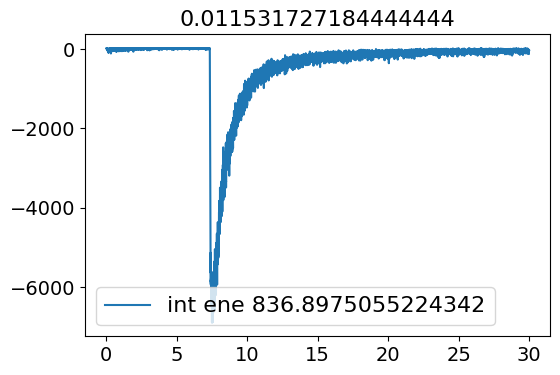

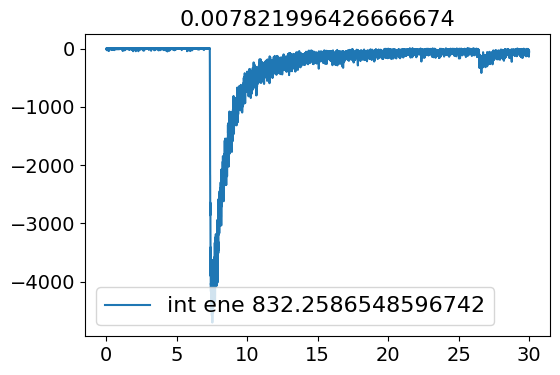

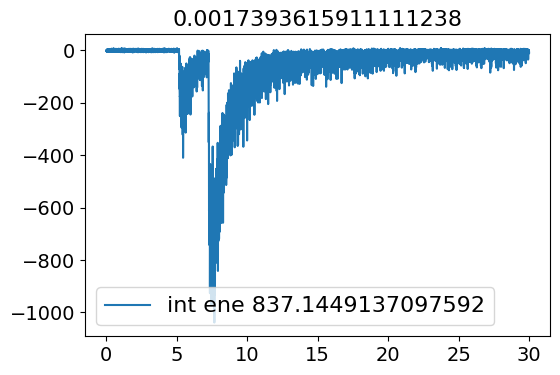

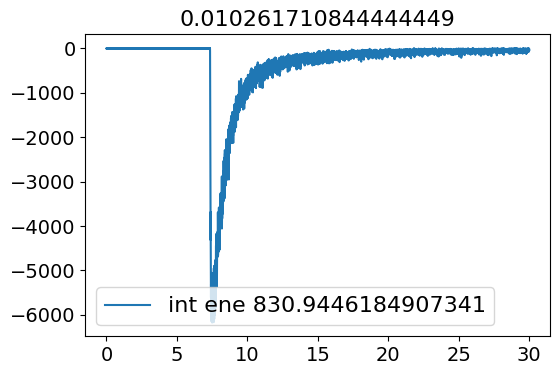

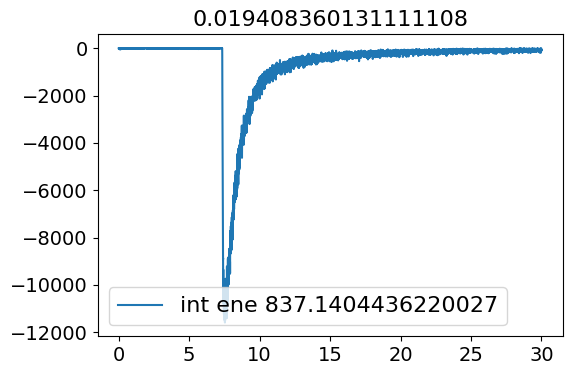

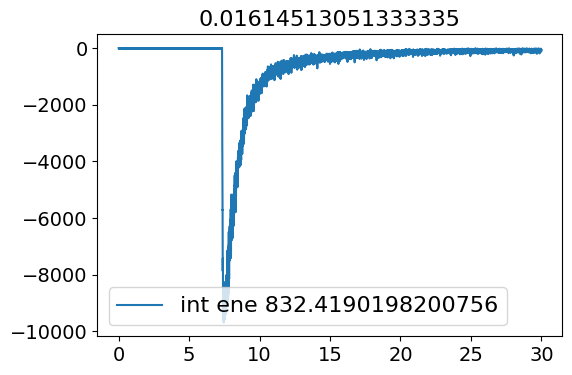

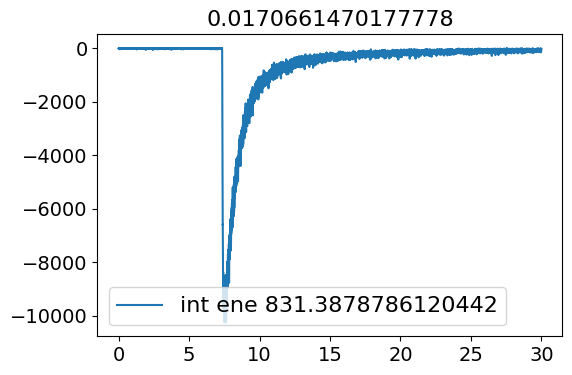

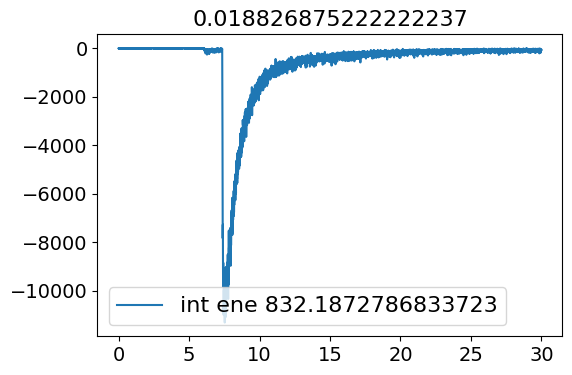

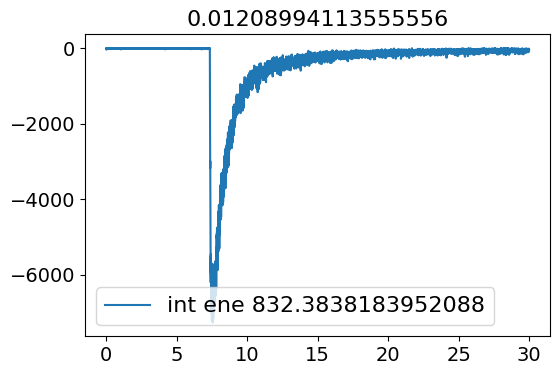

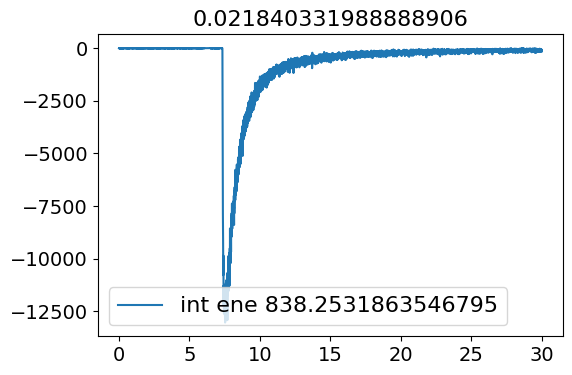

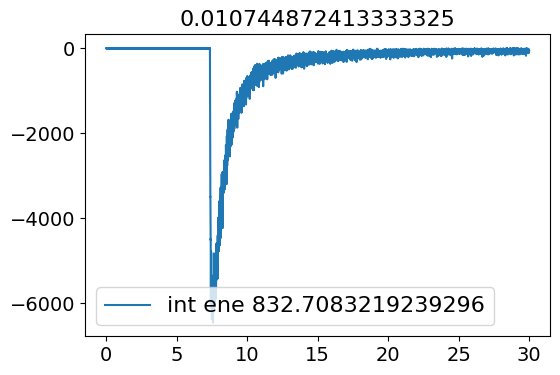

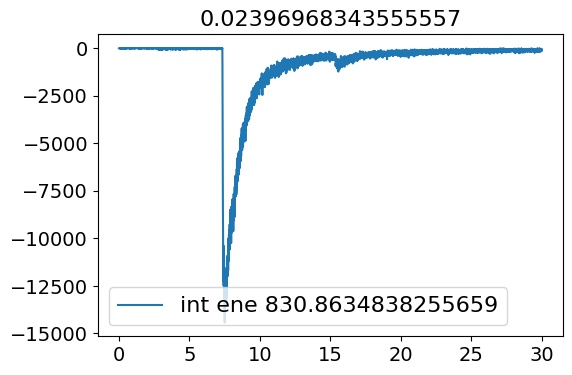

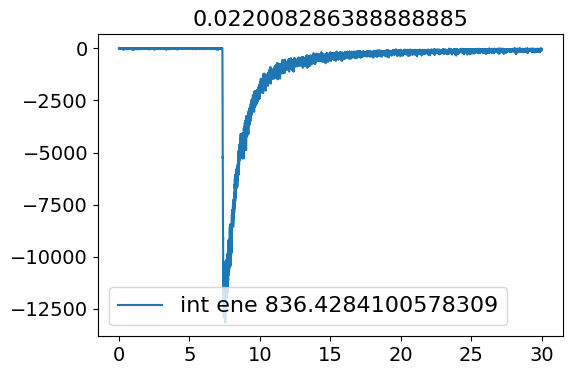

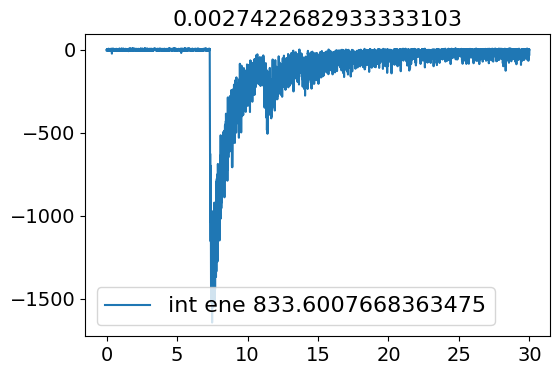

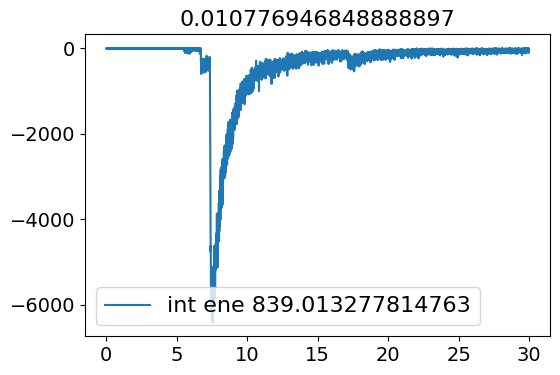

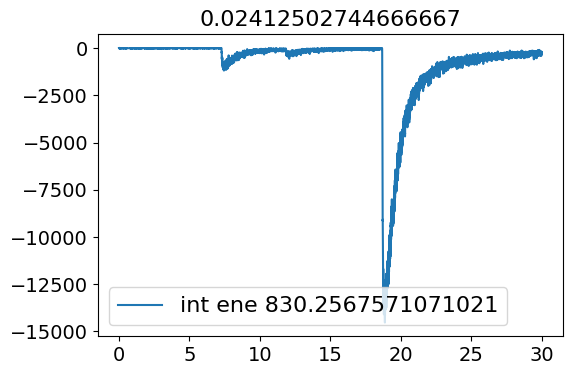

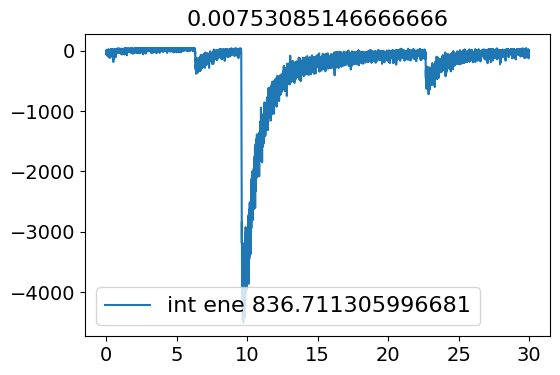

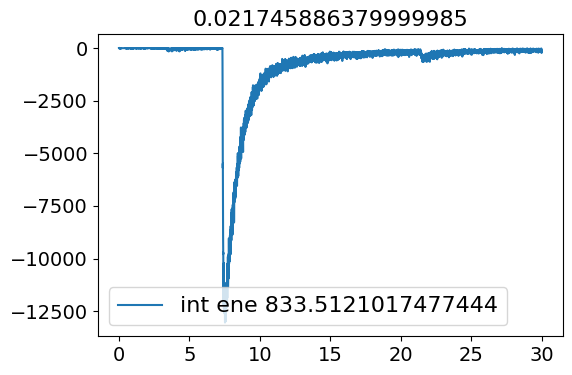

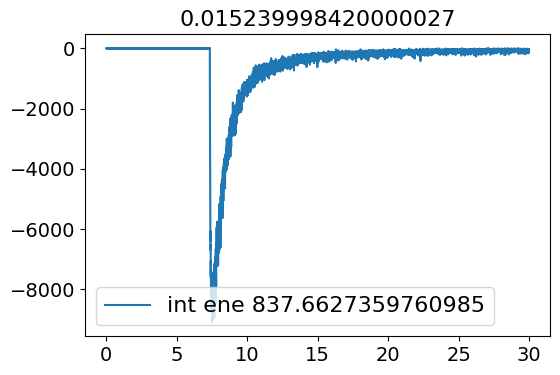

CPU times: user 34.7 s, sys: 2.54 s, total: 37.3 s
Wall time: 37.2 s


In [129]:
%%time
chunks = pd.read_csv("wavedumpdata/XFEL/wavedump_Tl_XFELtesting_21-07-09_02-27-57.txt", skiprows = 22140*15000 , chunksize = 15000*1000,  header = None)
norm_intXF_, norm_intXF  = [], []
for chunk in chunks:
    k+=1
    actual_block_size = int(chunk.shape[0]/15000)
    newdata = chunk[:actual_block_size*15000].values.reshape(actual_block_size, 15000)
    data_Tl= newdata-np.expand_dims(newdata[:,100:1000].mean(axis=1), axis=1)
#     print('pTl')
    clip_idx = clippedwaveformsindex(data_Tl, clippingstart = -15100)


    glitch_idx = glitchesindex(data_Tl)


    pileup_idx, noisy = pileupindex(data_Tl, ctype = 'Tl')
    pp = list(set(pileup_idx+glitch_idx+clip_idx+noisy)) 
    data_Tl = np.delete(data_Tl, pp, axis =0)  


    l , lo = np.sum(data_Tl/np.min(data_Tl, axis=1)[:,None], axis=1), -1* integrate.trapz(y = -data_Tl/np.min(data_Tl, axis=1)[:,None], dx = 2e-9, axis =1)

    norm_intXF = np.append(norm_intXF, lo, axis = 0) 
#     print(len(norm_intXF))
    norm_intXF_ = np.append(norm_intXF_, l, axis = 0) 
    for i in range(len(l)):
        if l[i] >830 and l[i]<840:
            plt.plot(np.arange(15000)*2e-3, data_Tl[i], label='int ene %s'%l[i])#color='blue', marker = '.' , alpha=0.5)
            plt.title(-1* integrate.trapz(y = data_Tl[i], dx = 2e-9 ))
            plt.legend()
            plt.show()
#         if lo[i] < 0.75e-6:
#         if lo[i] < 0.00004
#         if lo[i] > 0.021:
#             plt.plot(np.arange(15000)*2e-3, data_Tl[i], label='int ene %s'%l[i])#color='blue', marker = '.' , alpha=0.5)
#             plt.title(lo[i])
#             plt.legend()
#             plt.show()

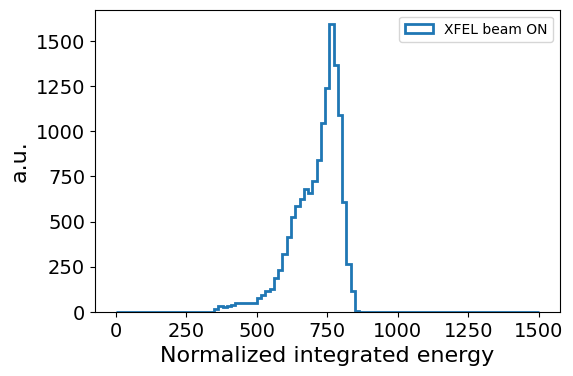

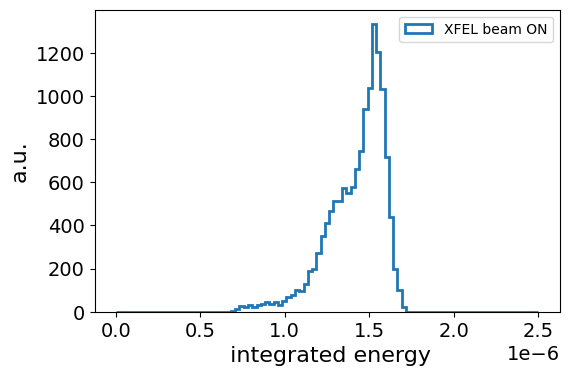

In [120]:
bins = np.linspace (0,1500, 100)
# plt.hist(norm_int_Tl_cosmics[:len(norm_intXF)], bins = bins, histtype = 'step', linewidth =2, label = 'Elab cosmics')
plt.hist(norm_intXF_, bins = bins, histtype = 'step',linewidth =2,  label = 'XFEL beam ON')
# plt.vlines([360,900], 0, 6200, color = 'red', linestyle = '--', label = 'int_energy cut')
# plt.title('CsI Tl - with glitches, pileups, clipped removed', fontsize =10 )
# plt.ylim(0,6000)
plt.ylabel('a.u.')
plt.xlabel('Normalized integrated energy')
plt.legend(fontsize =10 )
plt.show()
plt.hist(norm_intXF, bins = np.linspace (0,0.25e-5, 100), histtype = 'step',linewidth =2,  label = 'XFEL beam ON')
# plt.vlines([0.00004,0.0008], 0, 1500, color = 'red', linestyle = '--', label = 'int_energy cut')
# plt.title('CsI Tl - with glitches, pileups, clipped removed', fontsize =10 )
# plt.ylim(0,6000)
plt.ylabel('a.u.')
plt.xlabel(' integrated energy')
plt.legend(fontsize =10 )
plt.show()

In [111]:
for i in range(len(l)):
#     if l[i] >38 and l[i] <40:
#         plt.plot(np.arange(15000)*2e-3, data_Tl[i], label='int ene %s'%l[i])#color='blue', marker = '.' , alpha=0.5)
#         plt.title(-1* integrate.trapz(y = data_Tl[i], dx = 2e-9 ))
#         plt.legend()
#         plt.show()
#         if lo[i] < 0.0014:
        if lo[i] > 0.8e-7:
            plt.plot(np.arange(15000)*2e-3, data_Tl[i], label='int ene %s'%l[i])#color='blue', marker = '.' , alpha=0.5)
            plt.title(-1* integrate.trapz(y = data_Tl[i], dx = 2e-9 ))
            plt.legend()
            plt.show()

In [107]:
chunks = pd.read_csv("wavedumpdata/XFEL/wavedump_Tl_XFELtesting_21-07-09_02-27-57.txt", skiprows = 20000*15000 , chunksize = 15000*1000,  header = None)

for chunk in chunks:
    actual_block_size = int(chunk.shape[0]/15000)
#     print('ac = ', actual_block_size)
    newdata = chunk[:actual_block_size*15000].values.reshape(actual_block_size, 15000)
    data_Tl= newdata-np.expand_dims(newdata[:,100:1000].mean(axis=1), axis=1)


AttributeError: module 'matplotlib.pyplot' has no attribute 'plt'

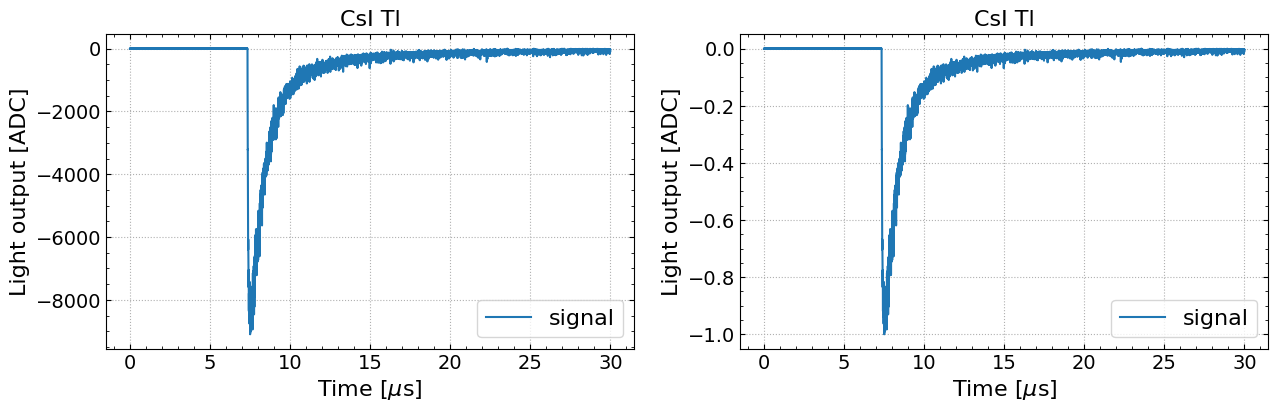

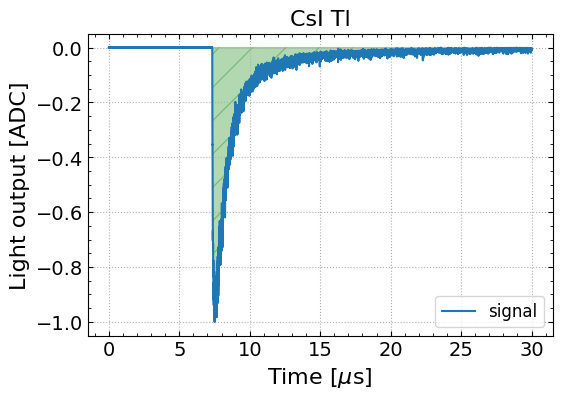

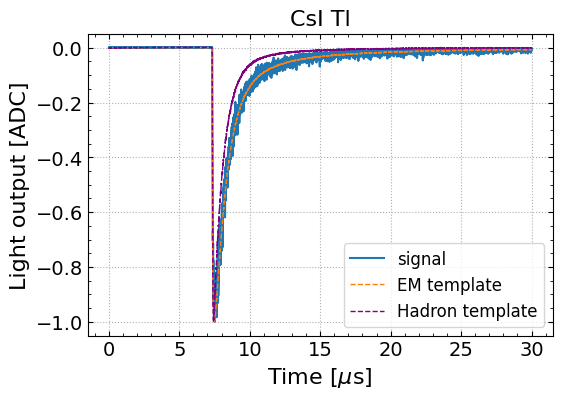

In [144]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(np.arange(15000)*2e-3, data_Tl[350], label = 'signal')
plt.ylabel(r'Light output [ADC]',fontsize = 16)
plt.xlabel(r'Time [$\mu$s]',fontsize = 16)
plt.title('CsI Tl',fontsize = 16)
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.legend(loc = 'lower right', fontsize =16)
#     plt.xlim(7.2,7.6)
plt.grid(linestyle='dotted')
plt.minorticks_on()
plt.subplot(2,2,2)
plt.plot(np.arange(15000)*2e-3, -data_Tl[350]/ min(data_Tl[350]), label = 'signal')
plt.ylabel(r'Light output [ADC]',fontsize = 16)
plt.xlabel(r'Time [$\mu$s]',fontsize = 16)
plt.title('CsI Tl',fontsize = 16)
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.legend(loc = 'lower right', fontsize =16)
#     plt.xlim(7.2,7.6)
plt.grid(linestyle='dotted')
plt.minorticks_on()
plt.show()
plt.plot(np.arange(15000)*2e-3, -data_Tl[350]/ min(data_Tl[350]), label = 'signal')
plt.fill_between(np.arange(15000)*2e-3,-data_Tl[350]/ min(data_Tl[350]),np.arange(15000)*0, hatch = '/', color = 'green', alpha = 0.3)
plt.ylabel(r'Light output [ADC]',fontsize = 16)
plt.xlabel(r'Time [$\mu$s]',fontsize = 16)
plt.title('CsI Tl',fontsize = 16)
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.legend(loc = 'lower right', fontsize =12)
#     plt.xlim(7.2,7.6)
plt.grid(linestyle='dotted')
plt.minorticks_on()
plt.show()
plt.plot(np.arange(15000)*2e-3, -data_Tl[350]/ min(data_Tl[350]), label = 'signal')
plt.plot(np.arange(15000)*2e-3,TemplateEM_Tl, label = 'EM template',linewidth = 1,  linestyle ='--')
plt.plot(np.arange(15000)*2e-3,TemplateHAD_Tl, label = 'Hadron template',linewidth = 1,  linestyle ='--', color = 'purple')
plt.ylabel(r'Light output [ADC]',fontsize = 16)
plt.xlabel(r'Time [$\mu$s]',fontsize = 16)
plt.title('CsI Tl',fontsize = 16)
plt.tick_params(which='both', direction='in', right=True, top=True)
#     plt.xlim(7.2,7.6)
plt.grid(linestyle='dotted')
plt.legend(loc = 'lower right', fontsize =12)
plt.minorticks_on()
plt.show()